<a href="https://colab.research.google.com/github/chris051091/Seminario-3/blob/master/anomalias/src/Anomalias_palanquero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install windrose

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from datetime import timedelta
import matplotlib.cm as cm
from functools import reduce
from math import cos, sin, atan, pi
from windrose import WindroseAxes
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH_DRIVE = 'drive/MyDrive/Seminario-3-master'
PATH_DADOS = '/preprocess/dados/'
PATH_DADOS_EVENTOS = '/dados/'
PATH_ANOMALIAS = '/anomalias/'
NOMBRE_ESTACION = 'palanquero'
FILE_DATOS_ESTACION = 'eventos_palanquero_2.csv'

LISTA_VAR = ['temp', 'hum', 'pres']
LISTA_PWV = ['pwv']
LISTA_VAR_10M = ['viento']
LISTA_PREC = ['prec']

PATH_FINAL_DADOS_TRATADOS = PATH_DRIVE + PATH_DADOS + NOMBRE_ESTACION + '/tratados/'
FILES_TRATADOS = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_VAR]
FILES_PWV = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_PWV]
FILES_TRATADOS_10M = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_VAR_10M]
FILES_TRATADOS_PREC = [NOMBRE_ESTACION.lower() + f'_tratados_{VAR.lower()}.csv' for VAR in LISTA_PREC]

Cargando datos de Temp, Hum, Pres

In [ ]:
dfList = []
for f in FILES_TRATADOS:
  df = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                  sep = ';', 
                )
  dfList.append(df)

In [ ]:
df = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)
df = df.sort_values(by=['FECHA']).reset_index(drop = True)
df['HORA'] = df['FECHA'].apply(lambda x: x[11:13])

Cargando datos de Vapor de Agua

In [ ]:
dfList = []
PWV_columns = []
if FILES_PWV:
    
  for f in FILES_PWV:
    dfp = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                    sep = ';', 
                  )
    dfList.append(dfp)
    PWV_columns += [col for col in dfp if col != 'FECHA']


  dfPWV = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)
  dfPWV = dfPWV.sort_values(by=['FECHA']).reset_index(drop = True)

  dfPWV['FECHA_HORA'] = dfPWV['FECHA'].apply(lambda x: x[0:13])
  dfPWV = dfPWV.groupby('FECHA_HORA').agg('mean').reset_index()

  for var in PWV_columns:
    dfPWV = dfPWV.loc[~dfPWV[var].isnull()].reset_index(drop = True)

  dfPWV['FECHA'] = pd.to_datetime(dfPWV['FECHA_HORA'], format='%Y-%m-%d %H').dt.tz_localize('America/Bogota').astype(str)
else:
  dfPWV = pd.DataFrame(columns = ['FECHA'])

In [ ]:
dfPWV

,FECHA_HORA,PWV,FECHA
0,2011-01-01 00,48.363636,2011-01-01 00:00:00-05:00
1,2011-01-01 01,48.830909,2011-01-01 01:00:00-05:00
2,2011-01-01 02,49.322727,2011-01-01 02:00:00-05:00
3,2011-01-01 03,48.856667,2011-01-01 03:00:00-05:00
4,2011-01-01 09,46.832000,2011-01-01 09:00:00-05:00
...,...,...,...
40050,2017-12-31 19,52.679091,2017-12-31 19:00:00-05:00
40051,2017-12-31 20,53.769091,2017-12-31 20:00:00-05:00
40052,2017-12-31 21,55.295455,2017-12-31 21:00:00-05:00
40053,2017-12-31 22,56.664545,2017-12-31 22:00:00-05:00


## Cargando datos de Vientos

$ \theta_p  = arctan(U_p / V_p) $ Direccíon del viento promedio

In [ ]:
dfList = []
for f in FILES_TRATADOS_10M:
  dfaux = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                  sep = ';', 
                )
  dfList.append(dfaux)

In [ ]:
df10m = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)

df10m['FECHA_HORA'] = df10m['FECHA'].apply(lambda x: x[0:13])
df10m['X_VIENTO'] = df10m['VELVIENTO'] * np.sin(np.deg2rad(df10m['DIRECVIENTO'] - 180))
df10m['Y_VIENTO'] = df10m['VELVIENTO'] * np.cos(np.deg2rad(df10m['DIRECVIENTO'] - 180))

dfViento = df10m.copy()

df10m = df10m.groupby('FECHA_HORA').agg({'X_VIENTO' : 'mean', 'Y_VIENTO' : 'mean' }).reset_index()
df10m['HORA'] = df10m['FECHA_HORA'].apply(lambda x: x[11:13])
df10m['FECHA'] = pd.to_datetime(df10m['FECHA_HORA'], format='%Y-%m-%d %H').dt.tz_localize('America/Bogota').astype(str)

In [ ]:
df10m

,FECHA_HORA,X_VIENTO,Y_VIENTO,HORA,FECHA
0,2011-01-02 00,-0.020676,-0.144283,00,2011-01-02 00:00:00-05:00
1,2011-01-02 01,-0.010329,-0.114271,01,2011-01-02 01:00:00-05:00
2,2011-01-02 02,-0.004356,-0.133153,02,2011-01-02 02:00:00-05:00
3,2011-01-02 03,-0.013790,-0.164974,03,2011-01-02 03:00:00-05:00
4,2011-01-02 04,-0.002036,-0.116649,04,2011-01-02 04:00:00-05:00
...,...,...,...,...,...
41343,2017-12-31 17,0.627704,-1.636584,17,2017-12-31 17:00:00-05:00
41344,2017-12-31 19,-0.112232,0.016378,19,2017-12-31 19:00:00-05:00
41345,2017-12-31 20,-0.102170,0.407207,20,2017-12-31 20:00:00-05:00
41346,2017-12-31 21,0.194049,-0.179630,21,2017-12-31 21:00:00-05:00


## Cargando datos de precipitación

In [ ]:
dfList = []
PREC_columns = []
if FILES_TRATADOS_PREC:
    
  for f in FILES_TRATADOS_PREC:
    dfp = pd.read_csv(PATH_FINAL_DADOS_TRATADOS + f,
                    sep = ';', 
                  )
    dfList.append(dfp)
    PREC_columns += [col for col in dfp if col != 'FECHA']


  dfPrec = reduce(lambda df1,df2: pd.merge(df1,df2,on='FECHA', how='outer'), dfList)
  dfPrec = dfPrec.sort_values(by=['FECHA']).reset_index(drop = True)

  # dfPWV['FECHA_HORA'] = dfPWV['FECHA'].apply(lambda x: x[0:13])
  # dfPWV = dfPWV.groupby('FECHA_HORA').agg('mean').reset_index()

  for var in PREC_columns:
    dfPrec = dfPrec.loc[~dfPrec[var].isnull()].reset_index(drop = True)

  # dfPWV['FECHA'] = pd.to_datetime(dfPWV['FECHA_HORA'], format='%Y-%m-%d %H').dt.tz_localize('America/Bogota').astype(str)
else:
  dfPrec = pd.DataFrame(columns = ['FECHA'])



In [ ]:
dfPrec

,FECHA,PREC
0,2011-01-01 00:10:00-05:00,0.0
1,2011-01-01 00:20:00-05:00,0.0
2,2011-01-01 00:30:00-05:00,0.0
3,2011-01-01 00:40:00-05:00,0.0
4,2011-01-01 00:50:00-05:00,0.0
...,...,...
278100,2017-12-31 23:10:00-05:00,0.0
278101,2017-12-31 23:20:00-05:00,0.0
278102,2017-12-31 23:30:00-05:00,0.0
278103,2017-12-31 23:40:00-05:00,0.0


## Cruzamiento de datos de Temp, hum y pres con PWV

In [ ]:
dfDatos = pd.merge(df[['FECHA', 'TEMP', 'HUM', 'PRESION']], dfPWV[['FECHA', 'PWV']], on = 'FECHA', how = 'outer')
dfDatos['HORA'] = dfDatos['FECHA'].apply(lambda x: x[11:13])

dfmean = dfDatos.groupby('HORA').agg('mean').reset_index(level=0)

columns_mean = [col for col in dfmean.columns if col != 'HORA']
for col in columns_mean:
  dfmean = dfmean.rename(columns={col : f'{col}_mean'})

dfmean

,HORA,TEMP_mean,HUM_mean,PRESION_mean,PWV_mean
0,00,24.602023,93.996656,990.357252,55.670397
1,01,24.310280,94.871467,989.928955,55.334776
2,02,24.065277,95.213324,989.517105,54.783669
3,03,23.824669,95.952575,989.360551,54.348051
4,04,23.624545,95.860717,989.524463,53.916396
5,05,23.476396,96.446680,989.957486,53.633150
6,06,23.392489,96.118200,990.549096,53.486145
7,07,24.552886,94.378837,991.286165,53.349843
8,08,26.403856,86.492383,991.815086,53.023588
9,09,28.146848,79.125812,991.753458,52.845932


## Cargando Df de los eventos

In [ ]:
dfEventos = pd.read_csv(PATH_DRIVE + PATH_DADOS_EVENTOS + FILE_DATOS_ESTACION, 
                 sep = ';'
                )
dfEventos = dfEventos.sort_values(by='date_min_t').reset_index(drop = True)
dfEventos['FECHA'] = pd.to_datetime(dfEventos['date_min_t'], format='%Y %m %d %H %M').dt.tz_localize('America/Bogota')
dfEventos['FECHA_MIN'] = dfEventos['FECHA'].dt.round('10min')  
dfEventos['FECHA'] = dfEventos['FECHA'].dt.round('H')
dfEventos = dfEventos[['FECHA', 'FECHA_MIN', 'min_t', 'lon_t', 'lat_t']]
dfEventos

,FECHA,FECHA_MIN,min_t,lon_t,lat_t
0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627
1,2011-04-09 23:00:00-05:00,2011-04-09 22:40:00-05:00,197.0,-74.693,5.627
2,2011-05-13 22:00:00-05:00,2011-05-13 22:20:00-05:00,187.8,-74.693,5.627
3,2011-06-06 22:00:00-05:00,2011-06-06 22:20:00-05:00,198.5,-74.693,5.484
4,2011-11-03 02:00:00-05:00,2011-11-03 02:20:00-05:00,191.9,-74.693,5.484
5,2011-11-06 03:00:00-05:00,2011-11-06 02:40:00-05:00,196.4,-74.693,5.627
6,2011-11-28 05:00:00-05:00,2011-11-28 04:40:00-05:00,227.3,-74.693,5.341
7,2011-12-11 03:00:00-05:00,2011-12-11 02:40:00-05:00,199.3,-74.693,5.484
8,2012-03-16 23:00:00-05:00,2012-03-16 22:40:00-05:00,193.6,-74.693,5.484
9,2012-03-20 23:00:00-05:00,2012-03-20 23:20:00-05:00,196.1,-74.693,5.627


# Cargando Eventos e encontrando intervalo n horas antes y después

In [ ]:
funtime = lambda x, hour : [x + timedelta(hours = h) for h in (range(0, hour+1) if hour > 0 else range(hour, 0))]

# [base - datetime.timedelta(days=x) for x in range(numdays)]
dfEventAn = dfEventos.copy()
# pd.set_option('display.max_colwidth', None)

# ==================================
int_horas = 4
int_minutes = int_horas * 6 * 10
# ==================================
dfEventAn['FECHA_ANTES'] = dfEventAn['FECHA'].apply(funtime, hour = -int_horas)
dfEventAn['FECHA_DESPUES'] = dfEventAn['FECHA'].apply(funtime, hour = int_horas)
dfEventAn['FECHA_INTERVALO'] = dfEventAn['FECHA_ANTES'] + dfEventAn['FECHA_DESPUES']
dfEventAn = dfEventAn.drop(columns=['FECHA_ANTES', 'FECHA_DESPUES']).explode('FECHA_INTERVALO')
dfEventAn['FECHA_POS'] = (dfEventAn['FECHA_INTERVALO'] - dfEventAn['FECHA'])/ pd.Timedelta(hours=1)
dfEventAn = dfEventAn.rename(columns={'FECHA' : 'FECHA_EVENTO', 'FECHA_INTERVALO': 'FECHA'}).reset_index()
dfEventAn['FECHA'] = dfEventAn['FECHA'].astype(str)


dfEventAn.head(15)

,index,FECHA_EVENTO,FECHA_MIN,min_t,lon_t,lat_t,FECHA,FECHA_POS
0,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 19:00:00-05:00,-4.0
1,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 20:00:00-05:00,-3.0
2,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 21:00:00-05:00,-2.0
3,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 22:00:00-05:00,-1.0
4,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 23:00:00-05:00,0.0
5,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-28 00:00:00-05:00,1.0
6,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-28 01:00:00-05:00,2.0
7,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-28 02:00:00-05:00,3.0
8,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-28 03:00:00-05:00,4.0
9,1,2011-04-09 23:00:00-05:00,2011-04-09 22:40:00-05:00,197.0,-74.693,5.627,2011-04-09 19:00:00-05:00,-4.0


# Cruzamiento con las variables metereológicas. En terminos de 1h


In [ ]:
dfCross = pd.merge(dfEventAn, dfDatos, on='FECHA', how = 'left')
dfCross['HORA'] = dfCross['FECHA'].apply(lambda x: x[11:13])
dfCross = pd.merge(dfCross, dfmean, on = 'HORA', how='left')

list_anomalias = []
for col in columns_mean:
  anomalia = f'{col}_anomalia'
  list_anomalias.append(anomalia)
  dfCross[anomalia] = dfCross[f'{col}'] - dfCross[f'{col}_mean'] 

dfAnomalia = dfCross[list_anomalias + ['FECHA_POS']].groupby('FECHA_POS').agg(['mean', 'std']).reset_index()

In [ ]:
dfAnomalia

FECHA_POS TEMP_anomalia           HUM_anomalia            PRESION_anomalia  \
                     mean       std         mean        std             mean   
0      -4.0      0.226235  1.320779    -0.523678   9.269516        -0.332308   
1      -3.0      0.349964  1.188915    -1.828672  11.798774        -0.394880   
2      -2.0      0.457180  1.135485    -0.830856  11.880874        -0.288266   
3      -1.0      0.393037  1.078524    -1.905379  11.218219        -0.341143   
4       0.0      0.120684  1.257764    -3.748762  13.082968        -0.146858   
5       1.0     -0.439633  1.242426    -2.428067  11.958939         0.109444   
6       2.0     -0.531372  1.141707    -2.550992  13.534547         0.018228   
7       3.0     -0.410947  0.987293    -2.073653  13.332997        -0.052008   
8       4.0     -0.524259  1.023989    -1.272743  12.723323         0.061906   

            PWV_anomalia            
        std         mean       std  
0  1.224394     2.751677  3.771588  
1  1.305966     3.256764  3.426964  
2  1.511063     3.491419  3.138265  
3  1.619211     3.484668  3.009741  
4  1.795704     2.735343  3.064673  
5  1.762536     1.788008  2.997425  
6  1.902275     1.628800  2.942431  
7  1.845615     1.952666  3.021484  
8  1.892017     2.064888  3.072541

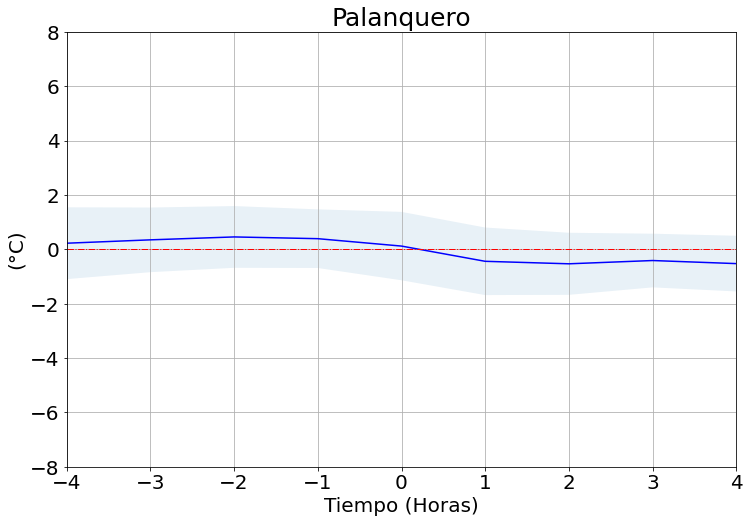

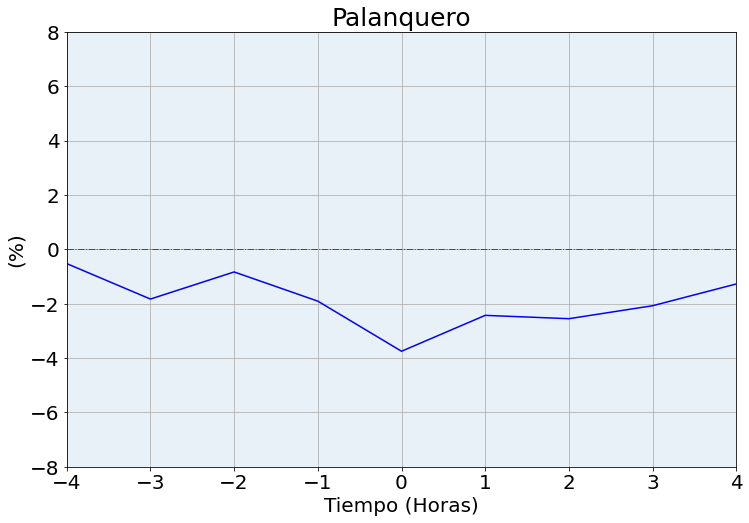

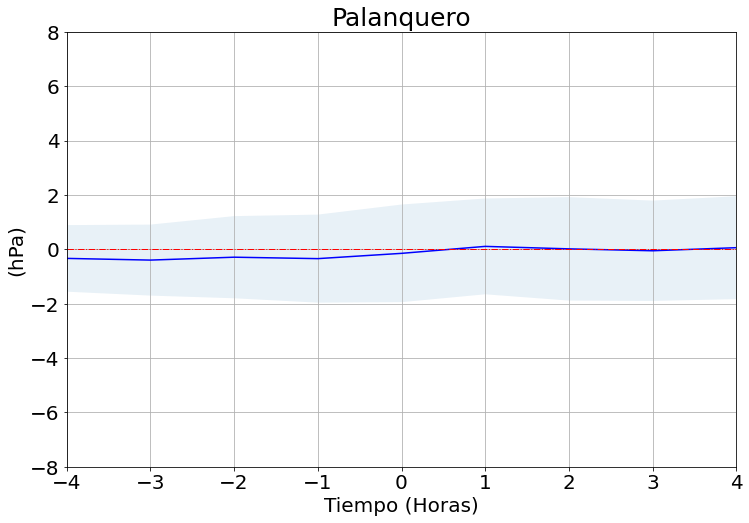

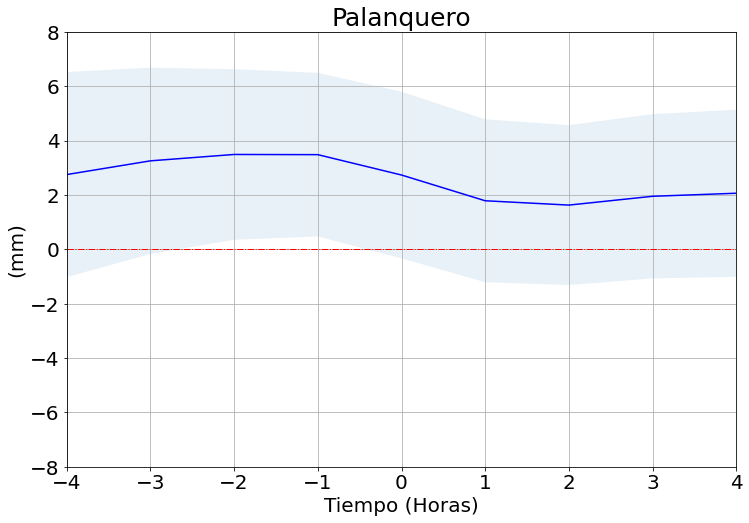

In [ ]:
def plot_anomalias(df, anomalia, titulo, name_to_save, ylabel_name, int_horas, ylimit = []):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0
  plt.xticks(df['FECHA_POS'], fontsize= 20)
  plt.plot(df['FECHA_POS'], df[(anomalia, 'mean')], color = 'b')
  plt.fill_between(df['FECHA_POS'], df[(anomalia, 'mean')] + df[(anomalia, 'std')], df[(anomalia, 'mean')] - df[(anomalia, 'std')], alpha=.1, linestyle = '--', linewidth = 0.5)
  plt.plot(df['FECHA_POS'], df['CERO'], color = 'r', linestyle = '-.', linewidth = 1)
  plt.grid()
  plt.xlim([-int_horas, int_horas])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Tiempo (Horas)", fontsize= 20)
  plt.ylabel(ylabel_name, fontsize= 20)
  plt.title("Palanquero", fontsize= 25)
  #plt.yticks(np.arange(-10, 10, 1))
  plt.ylim(-8,8)
  plt.yticks(fontsize= 20)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )

dict_names = {'TEMP_anomalia' : {'title' : 'Anomalias de Temperatura', 'name2save' : f'anomalias_temperatura_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(°C)'},
              'HUM_anomalia' : {'title' : 'Anomalias de Humedad', 'name2save' : f'anomalias_humedad_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(%)'},
              'PRESION_anomalia' : {'title' : 'Anomalias de Presion', 'name2save' : f'anomalias_presion_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(hPa)'},
              'PWV_anomalia' : {'title' : 'Anomalias de Vapor de agua', 'name2save' : f'anomalias_pwv_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(mm)'}
    }

for key in dict_names:
  plot_anomalias(dfAnomalia, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_horas)

# dfAnomalia

# Análisis con los 21 Eventos que tienen todas las variábles metereológicas completas

In [ ]:
dfEventos0 = dfCross.loc[dfCross['FECHA_POS'] == 0.]
dfEventos0 = dfEventos0[['FECHA_EVENTO', 'min_t', 'index'] + columns_mean]
dfEventos0['NUMERO_VARS'] = dfEventos0[columns_mean].notnull().sum(axis=1)
dfEventos0

,FECHA_EVENTO,min_t,index,TEMP,HUM,PRESION,PWV,NUMERO_VARS
4,2011-01-27 23:00:00-05:00,224.2,0,23.7,92.0,990.2,53.538182,4
13,2011-04-09 23:00:00-05:00,197.0,1,23.8,98.0,992.4,59.495455,4
22,2011-05-13 22:00:00-05:00,187.8,2,24.1,100.0,991.8,61.653636,4
31,2011-06-06 22:00:00-05:00,198.5,3,NaN,NaN,NaN,NaN,0
40,2011-11-03 02:00:00-05:00,191.9,4,25.6,NaN,988.4,56.503636,3
49,2011-11-06 03:00:00-05:00,196.4,5,23.7,NaN,988.9,59.640909,3
58,2011-11-28 05:00:00-05:00,227.3,6,NaN,NaN,NaN,NaN,0
67,2011-12-11 03:00:00-05:00,199.3,7,NaN,NaN,NaN,NaN,0
76,2012-03-16 23:00:00-05:00,193.6,8,NaN,NaN,NaN,NaN,0
85,2012-03-20 23:00:00-05:00,196.1,9,NaN,NaN,NaN,NaN,0


In [ ]:
dfEventos0.count()

FECHA_EVENTO    51
min_t           51
index           51
TEMP            36
HUM             26
PRESION         36
PWV             32
NUMERO_VARS     51
dtype: int64

In [ ]:
dfEventos0['NUMERO_VARS'].value_counts()

4    21
3    15
0    14
1     1
Name: NUMERO_VARS, dtype: int64

In [ ]:
dfVarsCompletas = dfEventos0.loc[dfEventos0['NUMERO_VARS'] == 4]
indexVarsCompletas = dfVarsCompletas['index']
dfVarsComp = pd.merge(dfCross, indexVarsCompletas, on = 'index', how = 'inner')

dfAnomaliaVarsComp = dfVarsComp[list_anomalias + ['FECHA_POS']].groupby('FECHA_POS').agg(['mean', 'std']).reset_index()
dfAnomaliaVarsComp

FECHA_POS TEMP_anomalia           HUM_anomalia            PRESION_anomalia  \
                     mean       std         mean        std             mean   
0      -4.0      0.219070  1.426882    -0.649077   8.938880         0.059415   
1      -3.0      0.313941  1.329001     1.015676   6.732479         0.107492   
2      -2.0      0.277828  1.217523     1.882621   7.192351         0.372204   
3      -1.0      0.324550  1.136754     0.363142   5.926568         0.291390   
4       0.0      0.249711  1.316245    -2.533803  10.652371         0.492235   
5       1.0     -0.401300  1.337328    -1.748364  10.526405         0.737630   
6       2.0     -0.538283  1.121891    -1.708408  11.395939         0.712654   
7       3.0     -0.493410  0.949121    -1.846760  11.496704         0.578472   
8       4.0     -0.752072  0.984212    -0.605294  11.463461         0.633390   

            PWV_anomalia            
        std         mean       std  
0  1.274862     2.083443  4.428076  
1  1.250502     2.602140  3.969517  
2  1.400386     2.868742  3.607619  
3  1.531643     2.867482  3.493517  
4  1.590972     2.303907  3.536191  
5  1.584790     1.286131  3.239916  
6  1.755924     0.846929  2.867861  
7  1.657401     1.129143  3.184373  
8  1.696372     1.101938  3.227764

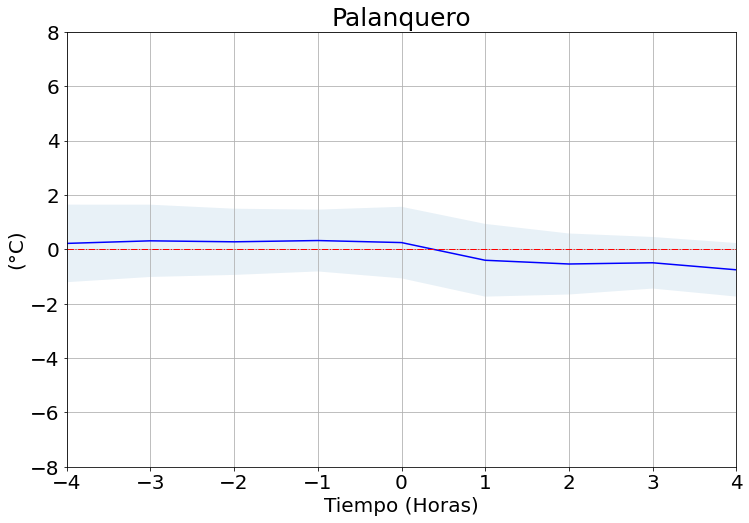

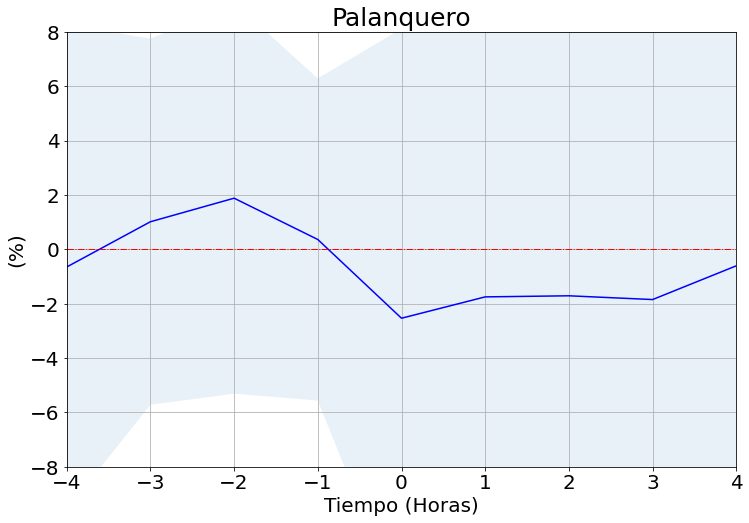

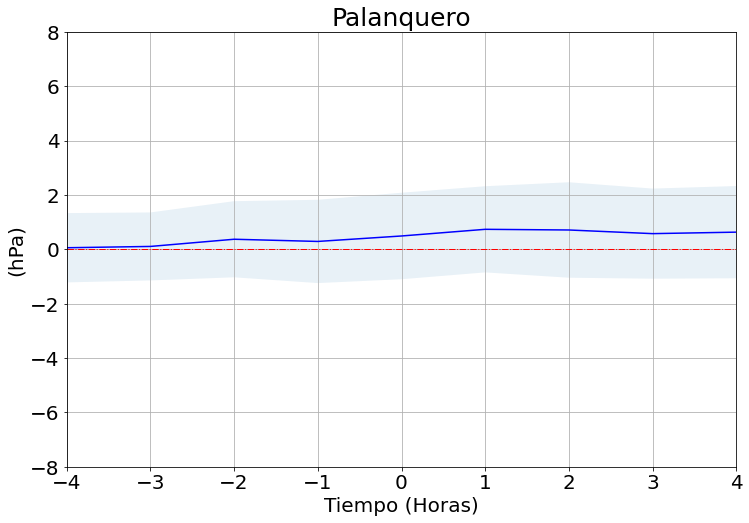

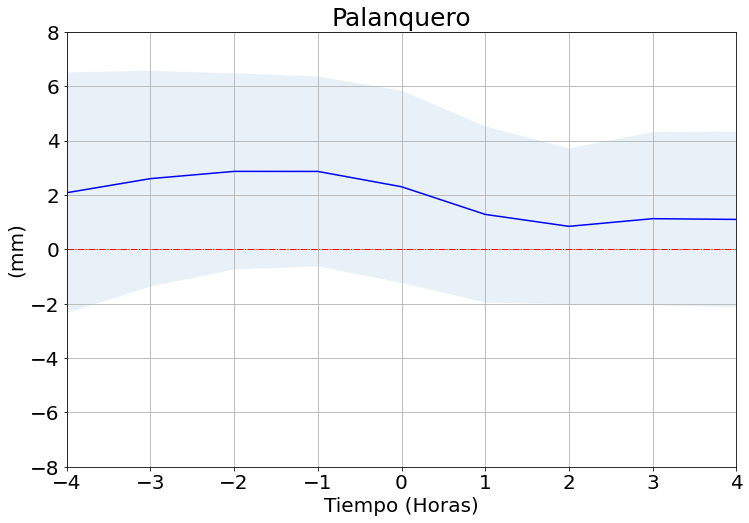

In [ ]:
dict_names = {'TEMP_anomalia' : {'title' : 'Anomalias de Temperatura', 'name2save' : f'anomalias_temperatura_vars_comp_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(°C)'},
              'HUM_anomalia' : {'title' : 'Anomalias de Humedad', 'name2save' : f'anomalias_humedad_vars_comp_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(%)'},
              'PRESION_anomalia' : {'title' : 'Anomalias de Presion', 'name2save' : f'anomalias_presion_vars_comp_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(hPa)'},
              'PWV_anomalia' : {'title' : 'Anomalias de Vapor de agua', 'name2save' : f'anomalias_pwv_vars_comp_{NOMBRE_ESTACION}_{int_horas}h.png', 'ylabel' : '(mm)'}
    }

for key in dict_names:
  plot_anomalias(dfAnomaliaVarsComp, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_horas)

# Análisis para Dirección del Viento 

In [ ]:
func_dir = lambda df, x, y: np.rad2deg(np.arctan2(df[x], df[y])) if np.arctan2(df[x], df[y]) > 0 else 360 + np.rad2deg(np.arctan2(df[x], df[y]))
func_vel = lambda df, x, y: (df[x]**2 + df[y]**2)**(1/2)

# df10mean['DIRVIENTO_mean'] = df10mean.apply(func_dir, x = 'X_VIENTO_mean', y='Y_VIENTO_mean', axis=1)
# df10mean['VELVIENTO_mean'] = df10mean.apply(func_vel, x = 'X_VIENTO_mean', y='Y_VIENTO_mean', axis=1)
df10m['DIRVIENTO'] = df10m.apply(func_dir, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
df10m['VELVIENTO'] = df10m.apply(func_vel, x = 'X_VIENTO', y='Y_VIENTO', axis=1)

In [ ]:
df10m

,FECHA_HORA,X_VIENTO,Y_VIENTO,HORA,FECHA,DIRVIENTO,VELVIENTO
0,2011-01-02 00,-0.020676,-0.144283,00,2011-01-02 00:00:00-05:00,188.154988,0.145757
1,2011-01-02 01,-0.010329,-0.114271,01,2011-01-02 01:00:00-05:00,185.165060,0.114737
2,2011-01-02 02,-0.004356,-0.133153,02,2011-01-02 02:00:00-05:00,181.873571,0.133225
3,2011-01-02 03,-0.013790,-0.164974,03,2011-01-02 03:00:00-05:00,184.778293,0.165550
4,2011-01-02 04,-0.002036,-0.116649,04,2011-01-02 04:00:00-05:00,181.000000,0.116667
...,...,...,...,...,...,...,...
41343,2017-12-31 17,0.627704,-1.636584,17,2017-12-31 17:00:00-05:00,159.015918,1.752832
41344,2017-12-31 19,-0.112232,0.016378,19,2017-12-31 19:00:00-05:00,278.302416,0.113421
41345,2017-12-31 20,-0.102170,0.407207,20,2017-12-31 20:00:00-05:00,345.914990,0.419829
41346,2017-12-31 21,0.194049,-0.179630,21,2017-12-31 21:00:00-05:00,132.790163,0.264428


# Cargando Eventos e encontrando intervalo m minutos antes y después

In [ ]:
funtimeMinutes = lambda x, minute : [x + timedelta(minutes = h) for h in (range(0, minute+1, 10) if minute > 0 else range(minute, 0, 10))]

dfEventAnMin = dfEventos.copy()

dfEventAnMin['FECHA_ANTES_MIN'] = dfEventAnMin['FECHA_MIN'].apply(funtimeMinutes, minute = -int_minutes)
dfEventAnMin['FECHA_DESPUES_MIN'] = dfEventAnMin['FECHA_MIN'].apply(funtimeMinutes, minute = int_minutes)

dfEventAnMin['FECHA_INTERVALO'] = dfEventAnMin['FECHA_ANTES_MIN'] + dfEventAnMin['FECHA_DESPUES_MIN']
dfEventAnMin = dfEventAnMin.drop(columns=['FECHA_ANTES_MIN', 'FECHA_DESPUES_MIN']).explode('FECHA_INTERVALO')
dfEventAnMin['FECHA_POS'] = (dfEventAnMin['FECHA_INTERVALO'] - dfEventAnMin['FECHA_MIN'])/ pd.Timedelta(minutes=1)
dfEventAnMin = dfEventAnMin.rename(columns={'FECHA_MIN' : 'FECHA_EVENTO', 'FECHA': 'FECHA_HORA', 'FECHA_INTERVALO': 'FECHA'}).reset_index(drop=True)
dfEventAnMin['FECHA'] = dfEventAnMin['FECHA'].astype(str)

dfEventAnMin.head(10)

,FECHA_HORA,FECHA_EVENTO,min_t,lon_t,lat_t,FECHA,FECHA_POS
0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 19:20:00-05:00,-240.0
1,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 19:30:00-05:00,-230.0
2,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 19:40:00-05:00,-220.0
3,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 19:50:00-05:00,-210.0
4,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 20:00:00-05:00,-200.0
5,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 20:10:00-05:00,-190.0
6,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 20:20:00-05:00,-180.0
7,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 20:30:00-05:00,-170.0
8,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 20:40:00-05:00,-160.0
9,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 20:50:00-05:00,-150.0


In [ ]:
dfCrossPrec = pd.merge(dfEventAnMin, dfPrec, on='FECHA', how = 'left')

dfCrossPrecGroup = dfCrossPrec.groupby("FECHA_POS").agg({"PREC" : ["mean", "std"]})
dfCrossPrecGroup = dfCrossPrecGroup.rename(columns = {("PREC", "mean") : "PREC_mean", ("PREC", "std") : "PREC_std"}).reset_index()

dfCrossPrecGroup

FECHA_POS      PREC          
                  mean       std
0     -240.0  0.283784  1.726189
1     -230.0  0.172973  1.052154
2     -220.0  0.021622  0.115795
3     -210.0  0.013889  0.083333
4     -200.0  0.011111  0.052251
5     -190.0  0.005556  0.033333
6     -180.0  0.350000  2.032100
7     -170.0  0.358333  1.733926
8     -160.0  0.188889  0.793105
9     -150.0  0.059459  0.313102
10    -140.0  0.045946  0.160891
11    -130.0  0.054054  0.266244
12    -120.0  0.040541  0.214035
13    -110.0  0.044444  0.234758
14    -100.0  0.055556  0.269862
15     -90.0  0.055556  0.252354
16     -80.0  0.077778  0.373486
17     -70.0  0.151429  0.810364
18     -60.0  0.137143  0.459594
19     -50.0  0.352778  1.135275
20     -40.0  0.200000  0.489314
21     -30.0  0.488889  1.683157
22     -20.0  0.830556  2.901804
23     -10.0  1.119444  2.702149
24       0.0  0.975000  3.025924
25      10.0  1.405556  3.732326
26      20.0  1.477778  3.697575
27      30.0  1.008333  2.686833
28      40.0  0.800000  2.362807
29      50.0  0.772222  1.937098
30      60.0  0.705556  1.868681
31      70.0  0.200000  0.453382
32      80.0  0.237838  0.792798
33      90.0  0.488889  2.225024
34     100.0  0.402778  1.544666
35     110.0  0.288889  0.863474
36     120.0  0.302703  0.979934
37     130.0  0.189189  0.392134
38     140.0  0.508108  2.245165
39     150.0  0.278378  0.900350
40     160.0  0.210811  0.632361
41     170.0  0.116216  0.232753
42     180.0  0.105405  0.251601
43     190.0  0.157143  0.616101
44     200.0  0.137143  0.546155
45     210.0  0.065714  0.226148
46     220.0  0.097143  0.473091
47     230.0  0.051429  0.188448
48     240.0  0.022857  0.059832

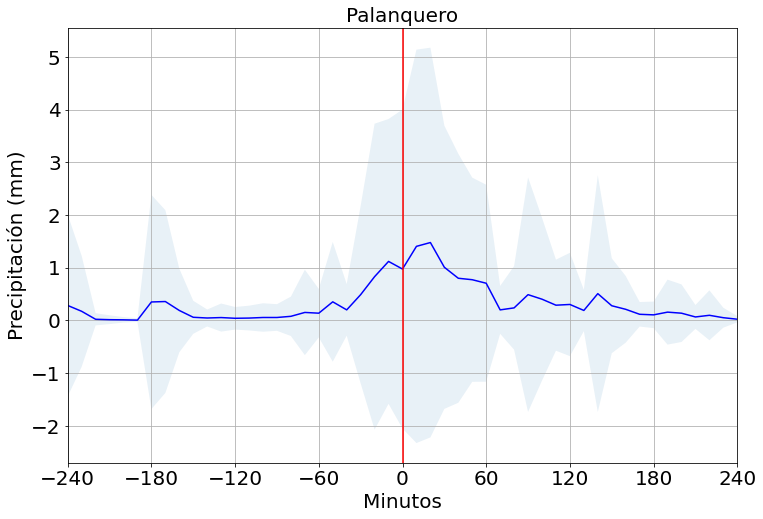

In [ ]:
def plot_10m_interval(df, campo, titulo, name_to_save, ylabel_name, int_minutes, ylimit = [], has_std = True):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0
  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency], fontsize= 20)
  plt.yticks(fontsize= 20)
  if has_std:
    plt.plot(df['FECHA_POS'], df[(campo, 'mean')], color = 'b')
    plt.fill_between(df['FECHA_POS'], df[(campo, 'mean')] + df[(campo, 'std')], df[(campo, 'mean')] - df[(campo, 'std')], alpha=.1, linestyle = '--', linewidth = 0.5)
  else:
    plt.plot(df['FECHA_POS'], df[campo], color = 'b')
  # plt.plot(df['FECHA_POS'], df['CERO'], color = 'r', linestyle = '-.', linewidth = 1)
  plt.grid()
  plt.axvline(color = 'r')
  plt.xlim([-int_minutes, int_minutes])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos", fontsize= 20)
  plt.ylabel(ylabel_name, fontsize= 20)
  plt.title("Palanquero", fontsize= 20)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )

dict_names = {'PREC' : {'title' : 'Análisis de Precipitación de eventos convectivos', 'name2save' : f'analisis_prec_{NOMBRE_ESTACION}_{int_minutes}m.png', 'ylabel' : 'Precipitación (mm)'},

    }

for key in dict_names.keys():
  plot_10m_interval(dfCrossPrecGroup, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_minutes)


## Análisis de percentiles - Precipitación

In [ ]:
def plot_percentil_interval_prec(df, campos, campo_analizar, titulo, name_to_save, ylabel_name, int_minutes, ylimit = []):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0

  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency],fontsize=20)
  plt.yticks(fontsize=20)
  if not .5 in campos:
    campos.append(.5)
  #for campo in campos:
    #plt.plot(df['FECHA_POS'], df[campo], label = f"Percentil {campo}")
  #plt.plot(df['FECHA_POS'], df[.5], label = f"Percentil")
  ## Gráfica del promedio 
  plt.plot(df['FECHA_POS'], df[(campo_analizar, 'mean')], linestyle = '--')

  ## Gráfica de la desviación standard
  plt.fill_between(df['FECHA_POS'], df[campos[0]] , df[campos[1]], alpha=.1, linestyle = '--', linewidth = 0.5)
  
  plt.axvline(color = 'r')
  plt.grid()
  plt.xlim([-int_minutes, int_minutes])
  plt.ylim(0,5)
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos",fontsize=20)
  plt.ylabel(ylabel_name,fontsize=20)
  plt.title("Palanquero",fontsize=20)
  plt.legend(fontsize=20)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  sort=sort,


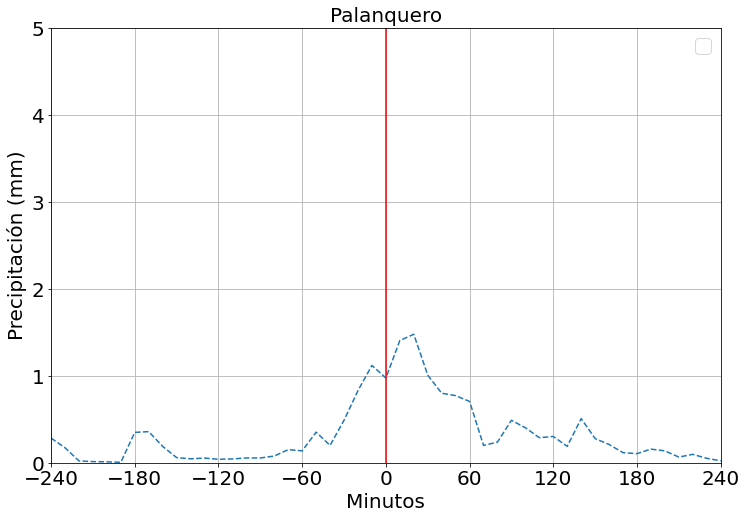

In [ ]:
list_percentil = [ 0.05, .1, .20, .25, .50, .75, .80, .90, 0.95]
dfCrossPrecNotNan = dfCrossPrec.dropna().reset_index()
dfPercentilPrec= dfCrossPrecNotNan.groupby("FECHA_POS")['PREC'].quantile(list_percentil).reset_index()
dfAggPrec = dfCrossPrecNotNan.groupby("FECHA_POS").agg({"PREC" : ["mean", "std"]})

dfPercentilPrec = dfPercentilPrec.pivot(index='FECHA_POS', columns='level_1')['PREC'].reset_index()
dfPercentilPrec = dfPercentilPrec.join(dfAggPrec, "FECHA_POS")

dict_names = {'title' : 'Análisis de precipitación', 
              'name2save' : f'analisis_precipitacion_percentil_{NOMBRE_ESTACION}_{int_minutes}m.png', 
              'ylabel' : 'Precipitación (mm)'
              }

plot_percentil_interval_prec(dfPercentilPrec, [.10, .10], 'PREC', dict_names['title'], dict_names['name2save'], dict_names['ylabel'], int_minutes)

In [ ]:
dfCrossPrecNotNan[dfCrossPrecNotNan['FECHA_POS'] == 0]

,index,FECHA_HORA,FECHA_EVENTO,min_t,lon_t,lat_t,FECHA,FECHA_POS,PREC
24,24,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 23:20:00-05:00,0.0,0.0
73,73,2011-04-09 23:00:00-05:00,2011-04-09 22:40:00-05:00,197.0,-74.693,5.627,2011-04-09 22:40:00-05:00,0.0,4.1
122,122,2011-05-13 22:00:00-05:00,2011-05-13 22:20:00-05:00,187.8,-74.693,5.627,2011-05-13 22:20:00-05:00,0.0,1.0
171,220,2011-11-03 02:00:00-05:00,2011-11-03 02:20:00-05:00,191.9,-74.693,5.484,2011-11-03 02:20:00-05:00,0.0,0.0
220,269,2011-11-06 03:00:00-05:00,2011-11-06 02:40:00-05:00,196.4,-74.693,5.627,2011-11-06 02:40:00-05:00,0.0,0.0
269,661,2012-09-11 05:00:00-05:00,2012-09-11 04:40:00-05:00,217.9,-74.693,5.484,2012-09-11 04:40:00-05:00,0.0,0.0
318,710,2012-10-30 01:00:00-05:00,2012-10-30 00:40:00-05:00,190.0,-74.693,5.627,2012-10-30 00:40:00-05:00,0.0,0.2
367,808,2013-07-03 00:00:00-05:00,2013-07-03 00:20:00-05:00,226.3,-74.693,5.627,2013-07-03 00:20:00-05:00,0.0,0.0
416,857,2013-07-05 01:00:00-05:00,2013-07-05 01:20:00-05:00,226.0,-74.693,5.484,2013-07-05 01:20:00-05:00,0.0,0.0
465,906,2013-07-05 04:00:00-05:00,2013-07-05 03:40:00-05:00,203.8,-74.693,5.627,2013-07-05 03:40:00-05:00,0.0,0.0


# Análisis de Viento

In [ ]:
func_dir = lambda df, x, y: np.rad2deg(np.arctan2(df[x], df[y])) if np.arctan2(df[x], df[y]) > 0 else 360 + np.rad2deg(np.arctan2(df[x], df[y]))
func_vel = lambda df, x, y: (df[x]**2 + df[y]**2)**(1/2)

In [ ]:
dfCrossVientos = pd.merge(dfEventAnMin, dfViento, on='FECHA', how = 'left')
# dfCrossVientos = dfCrossVientos.loc[dfCrossVientos['FECHA_POS'] == 240]
dfCrossVientos["X_VIENTO_STD"] = dfCrossVientos["X_VIENTO"]
dfCrossVientos["Y_VIENTO_STD"] = dfCrossVientos["Y_VIENTO"]


dfCrossVientosGroup = dfCrossVientos.groupby("FECHA_POS").agg({"X_VIENTO" : "mean", "Y_VIENTO" : "mean", "X_VIENTO_STD" : "std", "Y_VIENTO_STD" : "std"}).reset_index()
# dfCrossPrecGroup = dfCrossPrecGroup.rename(columns = {("PREC", "mean") : "PREC_mean", ("PREC", "std") : "PREC_std"}).reset_index()

dfCrossVientosGroup['DIR_VIENTO'] = dfCrossVientosGroup.apply(func_dir, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
dfCrossVientosGroup['DIR_VIENTO'] = (dfCrossVientosGroup['DIR_VIENTO'] + 180.0) % 360
dfCrossVientosGroup['VEL_VIENTO'] = dfCrossVientosGroup.apply(func_vel, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
dfCrossVientosGroup['VEL_VIENTO_MEAN'] = dfCrossVientosGroup.apply(func_vel, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
dfCrossVientosGroup['VEL_VIENTO_STD'] = dfCrossVientosGroup.apply(func_vel, x = 'X_VIENTO_STD', y='Y_VIENTO_STD', axis=1)


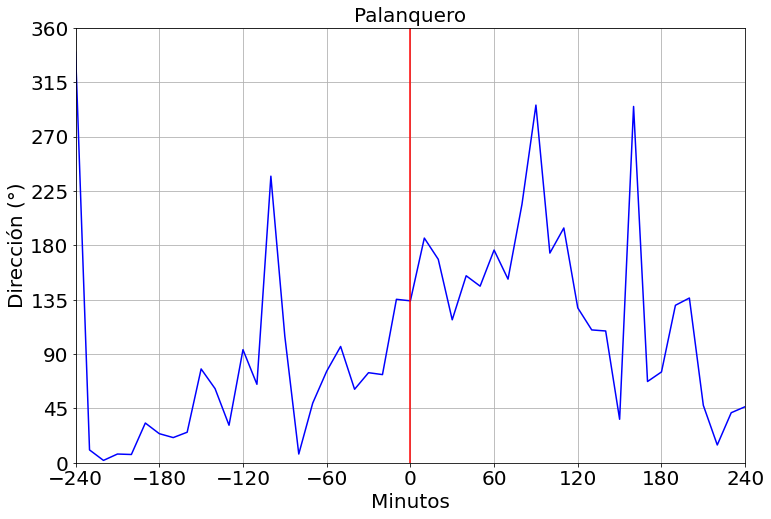

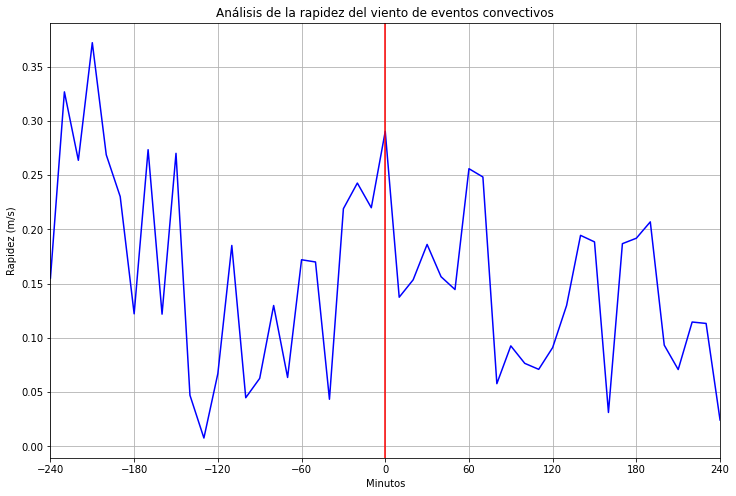

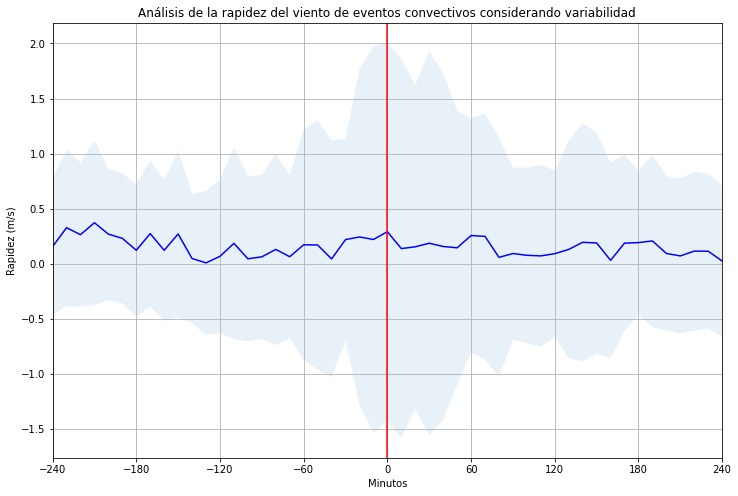

In [ ]:
def plot_10m_interval_v2(df, campo, titulo, name_to_save, ylabel_name, int_minutes, ylimit = [], has_std = True):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0
  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency])
  if has_std:
    plt.plot(df['FECHA_POS'], df[f"{campo}_MEAN"], color = 'b')
    plt.fill_between(df['FECHA_POS'], df[f"{campo}_MEAN"] + df[f"{campo}_STD"], df[f"{campo}_MEAN"] - df[f"{campo}_STD"], alpha=.1, linestyle = '--', linewidth = 0.5)
  else:
    plt.plot(df['FECHA_POS'], df[campo], color = 'b')
  # plt.plot(df['FECHA_POS'], df['CERO'], color = 'r', linestyle = '-.', linewidth = 1)
  plt.grid()
  plt.axvline(color = 'r')
  plt.xlim([-int_minutes, int_minutes])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos")
  plt.ylabel(ylabel_name)
  plt.title(titulo)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )

def plot_dir_viento_interval(df, campo, titulo, name_to_save, ylabel_name, int_minutes, ylimit = [], has_std = True):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0
  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency], fontsize= 20)
  plt.yticks(range(0, 361, 45), fontsize= 20)
  if has_std:
    plt.plot(df['FECHA_POS'], df[f"{campo}_MEAN"], color = 'b')
    plt.fill_between(df['FECHA_POS'], df[f"{campo}_MEAN"] + df[f"{campo}_STD"], df[f"{campo}_MEAN"] - df[f"{campo}_STD"], alpha=.1, linestyle = '--', linewidth = 0.5)
  else:
    plt.plot(df['FECHA_POS'], df[campo], color = 'b')
  plt.grid()
  plt.axvline(color = 'r')
  plt.xlim([-int_minutes, int_minutes])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos", fontsize= 20)
  plt.ylabel(ylabel_name, fontsize= 20)
  plt.title("Palanquero", fontsize= 20)

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )

dict_names = {'DIR_VIENTO' : {'title' : 'Análisis de la dirección del viento de eventos convectivos', 'name2save' : f'analisis_dir_viento_{NOMBRE_ESTACION}_{int_minutes}m.png', 'ylabel' : 'Dirección (°)'},
              'VEL_VIENTO' : {'title' : 'Análisis de la rapidez del viento de eventos convectivos', 'name2save' : f'analisis_vel_viento_{NOMBRE_ESTACION}_{int_minutes}m.png', 'ylabel' : 'Rapidez (m/s)'},
              'VEL_VIENTO_2' : {'title' : 'Análisis de la rapidez del viento de eventos convectivos considerando variabilidad', 'name2save' : f'analisis_vel_viento_std_{NOMBRE_ESTACION}_{int_minutes}m.png', 'ylabel' : 'Rapidez (m/s)'},
             }

key = 'DIR_VIENTO'
plot_dir_viento_interval(dfCrossVientosGroup, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_minutes, ylimit = [0, 360], has_std=False)

key = 'VEL_VIENTO'
plot_10m_interval_v2(dfCrossVientosGroup, key, dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_minutes, has_std=False)

key = 'VEL_VIENTO_2'
plot_10m_interval_v2(dfCrossVientosGroup, 'VEL_VIENTO', dict_names[key]['title'], dict_names[key]['name2save'], dict_names[key]['ylabel'], int_minutes, has_std=True)

## Anáisis de Percentiles

In [ ]:
dfCrossVientos

,FECHA_HORA_x,FECHA_EVENTO,min_t,lon_t,lat_t,FECHA,FECHA_POS,DIRECVIENTO,VELVIENTO,FECHA_HORA_y,X_VIENTO,Y_VIENTO,X_VIENTO_STD,Y_VIENTO_STD
0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 19:20:00-05:00,-240.0,1.0,0.1,2011-01-27 19,-0.001745,-0.099985,-0.001745,-0.099985
1,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 19:30:00-05:00,-230.0,1.0,0.1,2011-01-27 19,-0.001745,-0.099985,-0.001745,-0.099985
2,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 19:40:00-05:00,-220.0,1.0,0.1,2011-01-27 19,-0.001745,-0.099985,-0.001745,-0.099985
3,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 19:50:00-05:00,-210.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 20:00:00-05:00,-200.0,14.0,0.1,2011-01-27 20,-0.024192,-0.097030,-0.024192,-0.097030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,2017-11-14 01:00:00-05:00,2017-11-14 00:40:00-05:00,196.1,-74.693,5.627,2017-11-14 04:00:00-05:00,200.0,91.0,1.0,2017-11-14 04,-0.999848,0.017452,-0.999848,0.017452
2495,2017-11-14 01:00:00-05:00,2017-11-14 00:40:00-05:00,196.1,-74.693,5.627,2017-11-14 04:10:00-05:00,210.0,113.0,1.4,2017-11-14 04,-1.288707,0.547024,-1.288707,0.547024
2496,2017-11-14 01:00:00-05:00,2017-11-14 00:40:00-05:00,196.1,-74.693,5.627,2017-11-14 04:20:00-05:00,220.0,127.0,1.2,2017-11-14 04,-0.958363,0.722178,-0.958363,0.722178
2497,2017-11-14 01:00:00-05:00,2017-11-14 00:40:00-05:00,196.1,-74.693,5.627,2017-11-14 04:30:00-05:00,230.0,138.0,1.8,2017-11-14 04,-1.204435,1.337661,-1.204435,1.337661


In [ ]:
def plot_percentil_interval(df, campos, campo_analizar, titulo, name_to_save, ylabel_name, int_minutes, ylimit = []):
  plt.figure(figsize = (12,8))

  df['FECHA_POS'] = df['FECHA_POS'].astype(int)
  df['CERO'] = 0

  frequency = 6
  plt.xticks(df['FECHA_POS'][::frequency], fontsize= 20)
  plt.yticks(fontsize= 20)
  if not .5 in campos:
    campos.append(.5)
  #for campo in campos:
    #plt.plot(df['FECHA_POS'], df[campo], label = f"Percentil {campo}")
  plt.plot(df['FECHA_POS'], df[0.5], label = f"Percentil {0.5}")
  ## Gráfica del promedio 
  #plt.plot(df['FECHA_POS'], df[(campo_analizar, 'mean')], linestyle = '--')

  ## Gráfica de la desviación standard
  plt.fill_between(df['FECHA_POS'], df[campos[0]] , df[campos[1]], alpha=.1, linestyle = '--', linewidth = 0.5)
  
  plt.axvline(color = 'r')
  plt.grid()
  plt.xlim([-int_minutes, int_minutes])
  if ylimit:
    plt.ylim(*ylimit)
  plt.xlabel("Minutos", fontsize= 20)
  plt.ylabel(ylabel_name, fontsize= 20)
  plt.title("Palanquero", fontsize= 20)
  plt.legend()

  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + name_to_save, format='png', bbox_inches = 'tight' )


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  sort=sort,


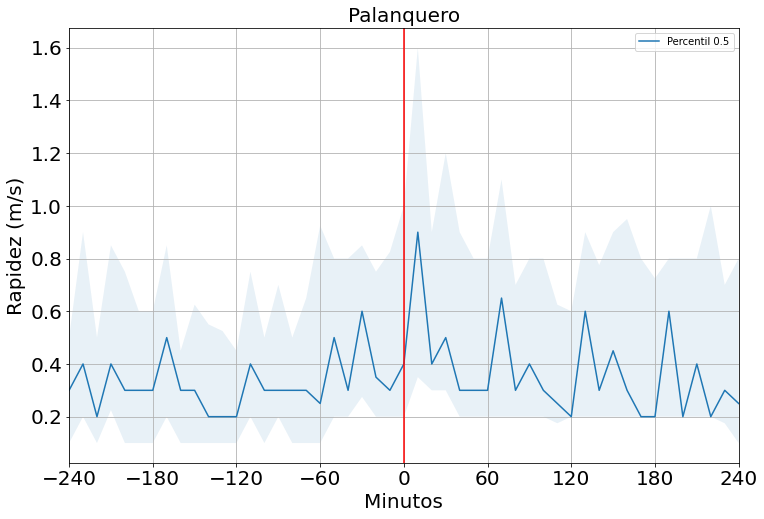

In [ ]:
list_percentil = [.10, .20,.25, .50, .75, .80, .90]
dfPercentilViento = dfCrossVientos.groupby("FECHA_POS")['VELVIENTO'].quantile(list_percentil).reset_index()
dfAggViento = dfCrossVientos.groupby("FECHA_POS").agg({"VELVIENTO" : ["mean", "std"]})

dfPercentilViento = dfPercentilViento.pivot(index='FECHA_POS', columns='level_1')['VELVIENTO'].reset_index()
dfPercentilViento = dfPercentilViento.join(dfAggViento, "FECHA_POS")

dict_names = {'title' : 'Análisis de rapidez del viento', 
              'name2save' : f'analisis_rapidez_viento_percentil_{NOMBRE_ESTACION}_{int_minutes}m.png', 
              'ylabel' : 'Rapidez (m/s)'
              }

plot_percentil_interval(dfPercentilViento, [.25, .75], 'VELVIENTO', dict_names['title'], dict_names['name2save'], dict_names['ylabel'], int_minutes)

# Análisis de viento por hora

In [ ]:
dfCrossVientosHora = pd.merge(dfEventAn, df10m, on='FECHA', how = 'left')

dfCrossVientosHora
# dfCrossVientosHoraGroup = dfCrossVientosHora.groupby("FECHA_POS").agg({"X_VIENTO" : "mean", "Y_VIENTO" : "mean"}).reset_index()

dfCrossVientosHora['DIR_VIENTO'] = dfCrossVientosHora.apply(func_dir, x = 'X_VIENTO', y='Y_VIENTO', axis=1)
dfCrossVientosHora['DIR_VIENTO'] = (dfCrossVientosHora['DIR_VIENTO'] + 180.0) % 360
dfCrossVientosHora['VEL_VIENTO'] = dfCrossVientosHora.apply(func_vel, x = 'X_VIENTO', y='Y_VIENTO', axis=1)

dfCrossVientosHora

,index,FECHA_EVENTO,FECHA_MIN,min_t,lon_t,lat_t,FECHA,FECHA_POS,FECHA_HORA,X_VIENTO,Y_VIENTO,HORA,DIRVIENTO,VELVIENTO,DIR_VIENTO,VEL_VIENTO
0,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 19:00:00-05:00,-4.0,2011-01-27 19,-0.003839,-0.139930,19,181.571393,0.139983,1.571393,0.139983
1,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 20:00:00-05:00,-3.0,2011-01-27 20,-0.005777,-0.116156,20,182.847375,0.116300,2.847375,0.116300
2,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 21:00:00-05:00,-2.0,2011-01-27 21,-0.035036,-0.129471,21,195.142119,0.134127,15.142119,0.134127
3,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 22:00:00-05:00,-1.0,2011-01-27 22,-0.031155,-0.098454,22,197.559407,0.103265,17.559407,0.103265
4,0,2011-01-27 23:00:00-05:00,2011-01-27 23:20:00-05:00,224.2,-74.693,5.627,2011-01-27 23:00:00-05:00,0.0,2011-01-27 23,-0.046361,-0.131477,23,199.423529,0.139412,19.423529,0.139412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,50,2017-11-14 01:00:00-05:00,2017-11-14 00:40:00-05:00,196.1,-74.693,5.627,2017-11-14 01:00:00-05:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
455,50,2017-11-14 01:00:00-05:00,2017-11-14 00:40:00-05:00,196.1,-74.693,5.627,2017-11-14 02:00:00-05:00,1.0,2017-11-14 02,0.115068,-0.585969,02,168.890042,0.597161,348.890042,0.597161
456,50,2017-11-14 01:00:00-05:00,2017-11-14 00:40:00-05:00,196.1,-74.693,5.627,2017-11-14 03:00:00-05:00,2.0,2017-11-14 03,-0.239530,-0.607192,03,201.528600,0.652730,21.528600,0.652730
457,50,2017-11-14 01:00:00-05:00,2017-11-14 00:40:00-05:00,196.1,-74.693,5.627,2017-11-14 04:00:00-05:00,3.0,2017-11-14 04,-0.786721,0.552925,04,305.100419,0.961590,125.100419,0.961590


In [ ]:
def plot_windrose(df, title, path_to_save):
  ax = WindroseAxes.from_ax()

  ax.bar(df['DIR_VIENTO'], df['VEL_VIENTO'], normed=True, opening=0.8, bins=np.arange(0.0, 5, 0.5), edgecolor='white', cmap=cm.cool)
  ax.set_legend(loc = 3)
  ax.set_xticklabels(['E', 'NE', 'N', 'NW',  'W', 'SW', 'S', 'SE'])
  plt.title(title)
  plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + path_to_save, format='png', bbox_inches = 'tight' )
  plt.show()

In [ ]:
posHoras = set(list(dfCrossVientosHora['FECHA_POS']))
posHoras

{-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0}

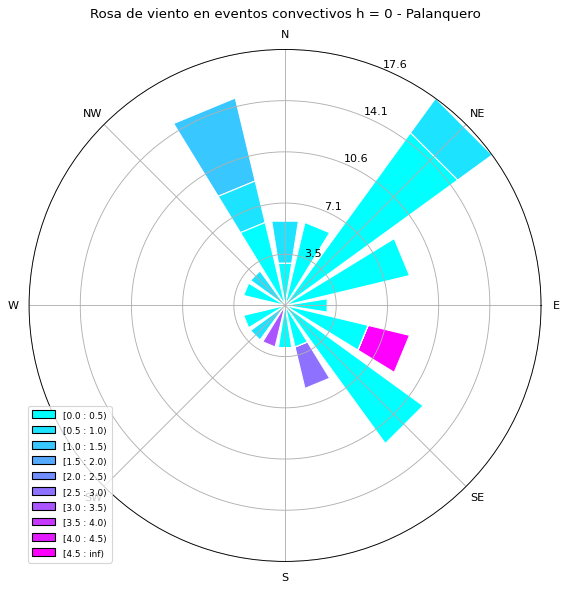

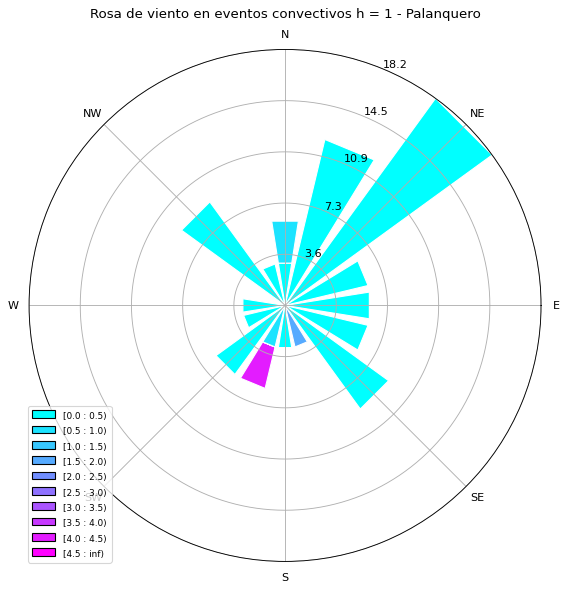

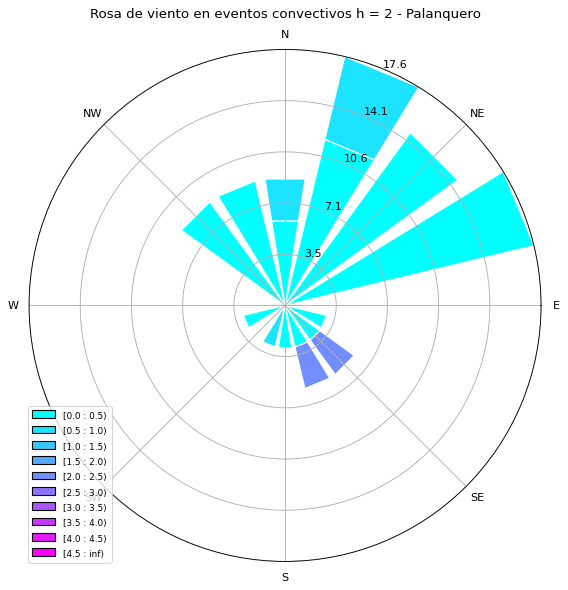

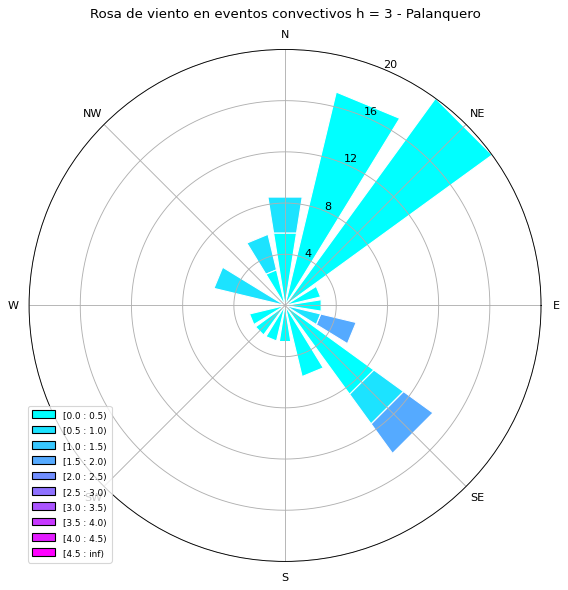

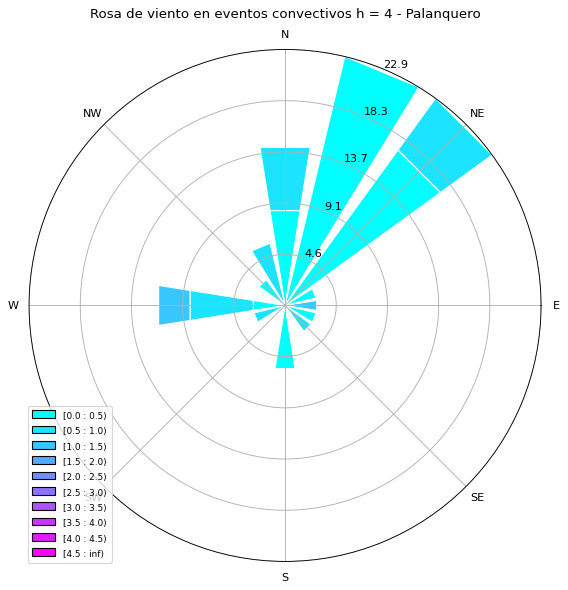

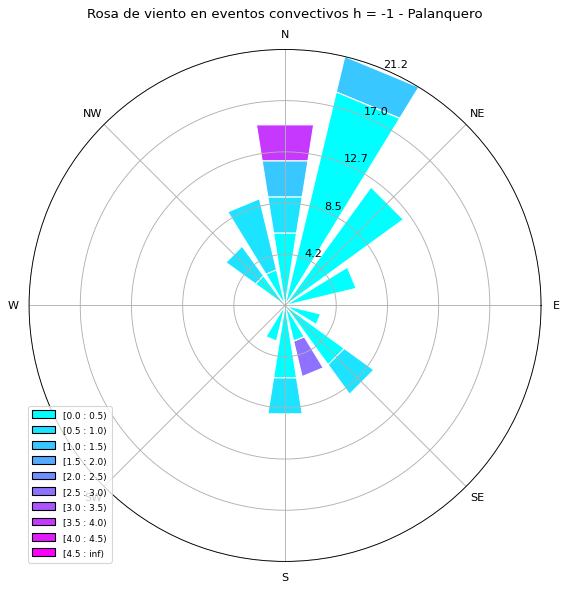

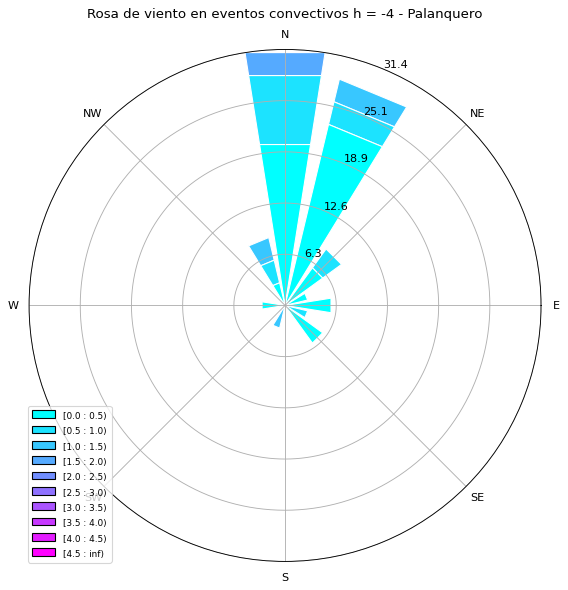

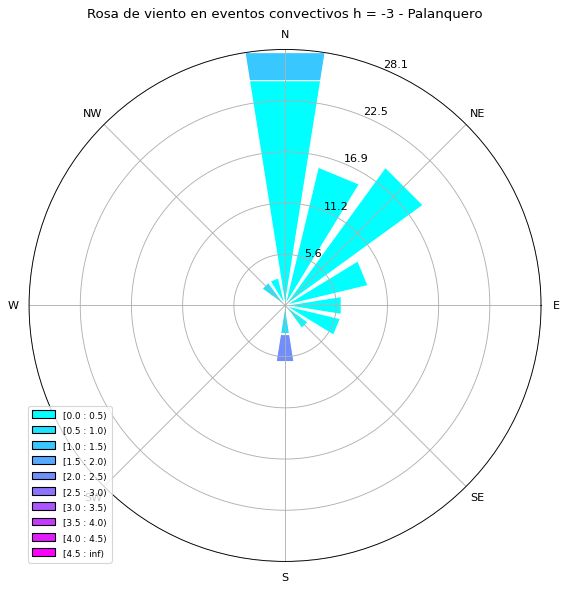

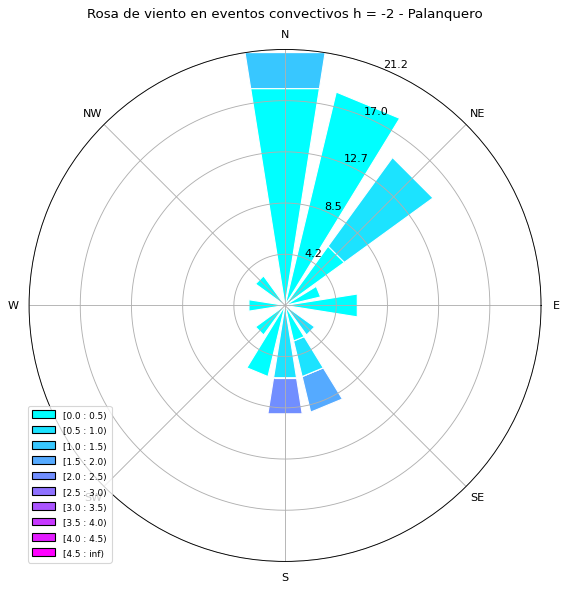

In [ ]:
for hora in posHoras:
  dft = dfCrossVientosHora.loc[dfCrossVientosHora['FECHA_POS'] == hora]
  title = f'Rosa de viento en eventos convectivos h = {int(hora)} - {NOMBRE_ESTACION.capitalize()}'
  path_to_save = f'windrose_eventos_convectivos_hora_{int(hora)}_{NOMBRE_ESTACION.lower()}.png'
    
  plot_windrose(dft, title, path_to_save)

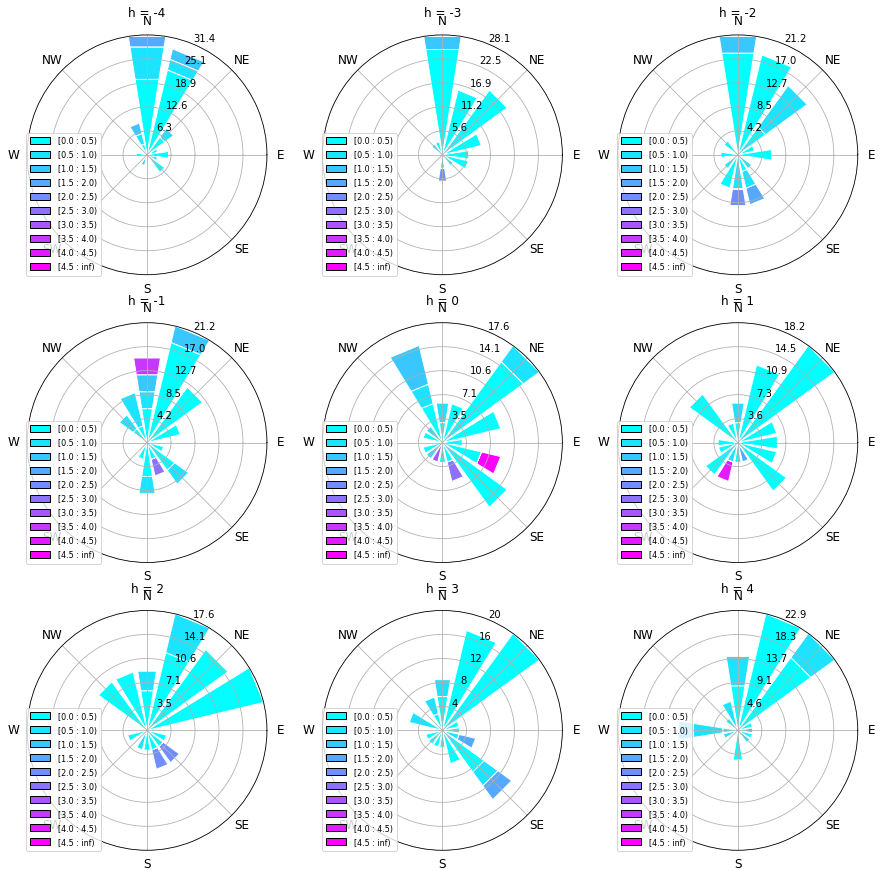

In [ ]:
def plot_windrose_2(df, title, ax):
  ax.bar(df['DIR_VIENTO'], df['VEL_VIENTO'], normed=True, opening=0.8, bins=np.arange(0.0, 5, 0.5), edgecolor='white', cmap=cm.cool)
  ax.set_legend(loc = 3)
  ax.set_xticklabels(['E', 'NE', 'N', 'NW',  'W', 'SW', 'S', 'SE'], fontsize= 12)
  ax.set_title(title)


fig, axs = plt.subplots(3, 3,figsize=(15,15),  subplot_kw=dict(projection="windrose"))
horas = list(posHoras)
horas.sort()

for ax, hora in zip(axs.reshape(9), horas):
  dft = dfCrossVientosHora.loc[dfCrossVientosHora['FECHA_POS'] == hora]
  title = f'h = {int(hora)}'
  plot_windrose_2(dft, title, ax)

path_to_save = f'subplot_vientos_{NOMBRE_ESTACION}.png'
plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + path_to_save, format='png', bbox_inches = 'tight' )
plt.show()

# Gráficos multivariables en único Plot

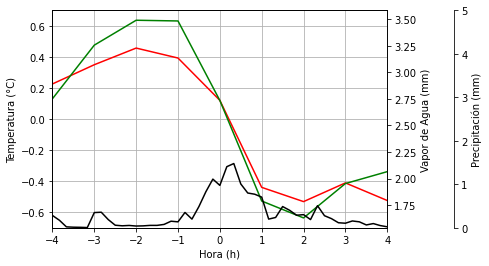

In [ ]:
fig, ax = plt.subplots()
ax.plot(dfAnomalia['FECHA_POS'], dfAnomalia[('TEMP_anomalia', 'mean')], c = 'red')
ax.set_ylim(-0.7, 0.7)

ax2=ax.twinx()
ax2.plot(dfAnomalia['FECHA_POS'], dfAnomalia[('PWV_anomalia', 'mean')], c = 'green')

ax3=ax.twinx()
ax3.spines['right'].set_position(('axes', 1.2))
ax3.plot(dfCrossPrecGroup['FECHA_POS']/60.0, dfCrossPrecGroup[('PREC', 'mean')], c = 'black')
ax3.set_ylim(0, 5)

ax.set_xlim(-4, 4)
ax.grid()

ax.set_ylabel("Temperatura (°C)")
ax2.set_ylabel("Vapor de Agua (mm)")
ax3.set_ylabel("Precipitación (mm)")
ax.set_xlabel("Hora (h)")

path_to_save = f'temp_vs_pwv_vs_prec_anomalias_{NOMBRE_ESTACION}.png'
plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + path_to_save, format='png', bbox_inches = 'tight' )

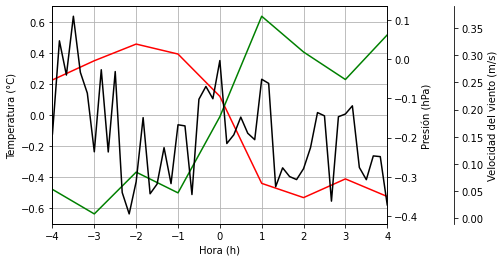

In [ ]:
fig, ax = plt.subplots()
ax.plot(dfAnomalia['FECHA_POS'], dfAnomalia[('TEMP_anomalia', 'mean')], c = 'red')
ax.set_ylim(-0.7, 0.7)

ax2=ax.twinx()
ax2.plot(dfAnomalia['FECHA_POS'], dfAnomalia[('PRESION_anomalia', 'mean')], c = 'green')

ax3=ax.twinx()
ax3.spines['right'].set_position(('axes', 1.2))
ax3.plot(dfCrossVientosGroup['FECHA_POS']/60.0, dfCrossVientosGroup['VEL_VIENTO'], c = 'black')
# ax3.set_ylim(0, 0.5)

ax.set_xlim(-4, 4)
ax.grid()

ax.set_ylabel("Temperatura (°C)")
ax2.set_ylabel("Presión (hPa)")
ax3.set_ylabel("Velocidad del viento (m/s)")
ax.set_xlabel("Hora (h)")

path_to_save = f'temp_vs_pres_vs_velviento_anomalias_{NOMBRE_ESTACION}.png'
plt.savefig(PATH_DRIVE + PATH_ANOMALIAS + f'{NOMBRE_ESTACION}/'  + path_to_save, format='png', bbox_inches = 'tight' )